In [1]:
import numpy as np 
import pandas as pd 
import xarray as xr 
from matplotlib import pyplot as plt 
import glob
import dask.array as da
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
from matplotlib import colors, cm

## Make heatmaps of log likelihoods

In [2]:
#get viridis colormaps
def cmap_codes(name, number):
    cmap = cm.get_cmap(name, number) 
    hexcodes = []
    for i in range(cmap.N): 
        hexcodes.append(colors.rgb2hex(cmap(i)[:3]))
    return hexcodes

cmap_codes('viridis', 4)

['#440154', '#31688e', '#35b779', '#fde725']

Text(0.5, 1, 'fennoscandia 12000 - 1500 yrs \n GLAC-1D : 96 km lithosphere')

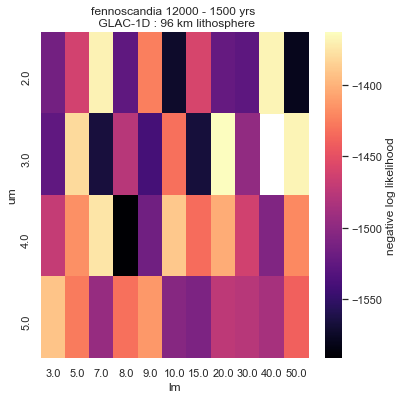

In [121]:
tmax = 12000
tmin = 1500
model = 'GLAC-1D'
mantle = 'l96C'
lith = '96'
place = 'fennoscandia'
dirName = f'figs/{place}/'
path_gen = f'{tmax}_{tmin}_{model}_{mantle}_{place}'

all_files = glob.glob(f'output/12000*{place}*likelihood')
df = pd.concat((pd.read_csv(f, index_col=None) for f in all_files)) 

df['ice_model'] = [key.split('_l')[0] for key in df.modelrun]
df['lith'] = [key.split('_')[-3:][0] for key in df.modelrun]
df['um'] = [key.split('_')[-3:][1][-1] for key in df.modelrun]
df['lm'] = [key.split('_')[-3:][2][2:] for key in df.modelrun]

df.lm = df.lm.astype(float)
df.um = df.um.astype(float)

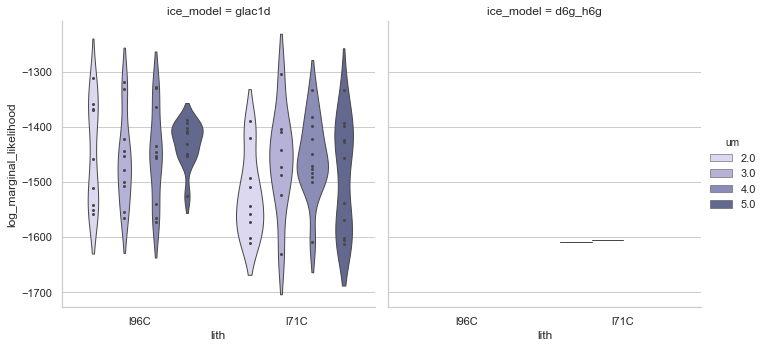

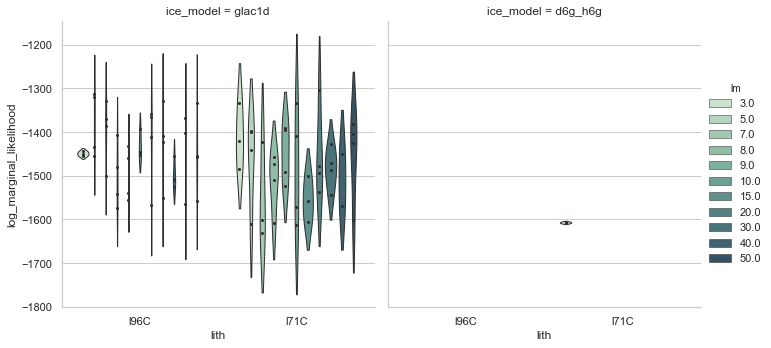

In [137]:
sns.set(style="whitegrid")

pal = sns.cubehelix_palette(4, start=2.8, rot=.1, dark=0.4)

# sns.swarmplot(x='lith', y="log_marginal_likelihood", hue='lm', data=df, palette='magma')
# sns.violinplot(x='lith', y="log_marginal_likelihood", data=df, hue='um', inner=None)
sns.catplot(x='lith', y="log_marginal_likelihood", data=df, hue='um', kind='violin', 
            bw=0.5, cut=1.5, linewidth=1, inner='points', palette=pal,
           col='ice_model')
# sns.catplot(x='lith', y="log_marginal_likelihood", data=df[df.ice_model == 'glac1d'], kind='violin', split=True, palette={"UM": "um", "No": "lm"})


plt.show()
pal = sns.cubehelix_palette(11, rot=-.4, dark=0.3)

sns.catplot(x='lith', y="log_marginal_likelihood", data=df, hue='lm', kind='violin', palette=pal, inner='points',
           col='ice_model', bw=0.8, cut=1.5, linewidth=1,)


In [143]:
df_glac = df[df.ice_model == 'glac1d']
df_glac1d_l96C = df_glac[df_glac.lith == 'l96C']
df_glac1d_l71C = df_glac[df_glac.lith == 'l71C']

df_6g = df[df.ice_model == 'd6g_h6g']
df_d6g_h6g_l96C = df_6g[df_6g.lith == 'l71C']
df_d6g_h6g_l71C = df_6g[df_6g.lith == 'l71C']

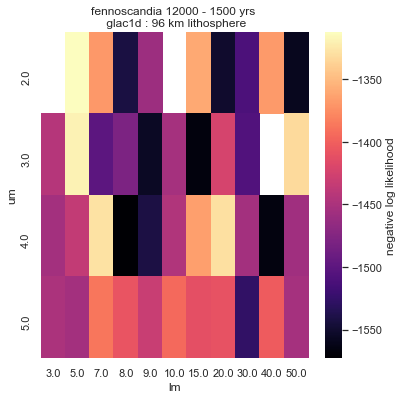

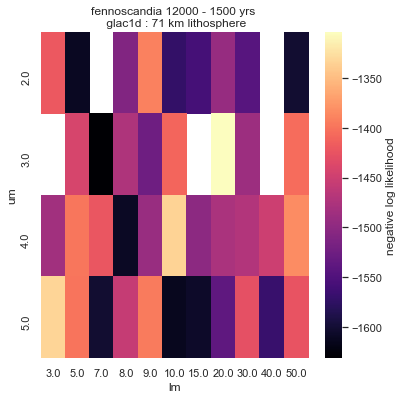

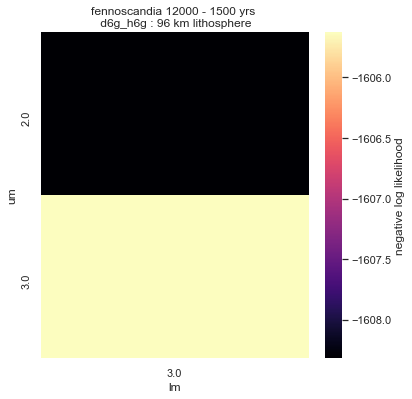

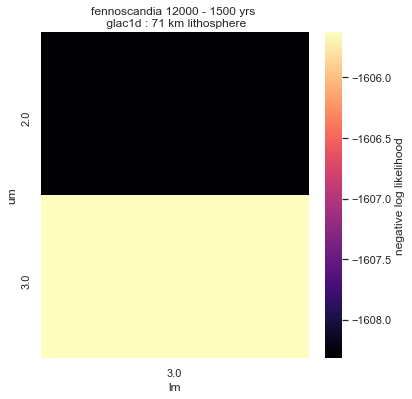

In [145]:
def make_heatmap(df, model, lith):
    heatmap = df.pivot_table(index='um', columns='lm', values='log_marginal_likelihood')

    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    sns.heatmap(heatmap,  cmap='magma', ax=ax,  cbar_kws={'label': 'negative log likelihood'})
    ax.set_title('label')

    ax.set_title(f'{place} {tmax} - {tmin} yrs \n {model} : {lith} km lithosphere')
    plt.show()
    
model = ['d6g_h6g', 'glac1d']
lith = ['l71C', 'l96C']


# for i, mod in enumerate(model):
#     for j, lit in enumerate(lith):
#         df_it = df_
#         make_heatmap(df)

make_heatmap(df_glac1d_l96C, 'glac1d', '96')
make_heatmap(df_glac1d_l71C, 'glac1d', '71')
make_heatmap(df_d6g_h6g_l96C, 'd6g_h6g', '96')
make_heatmap(df_d6g_h6g_l71C, 'glac1d', '71')

# fig.savefig(dirName + f'{path_gen}_likelihood_heatmap', transparent=True)


## Make datasets with gp regression model output

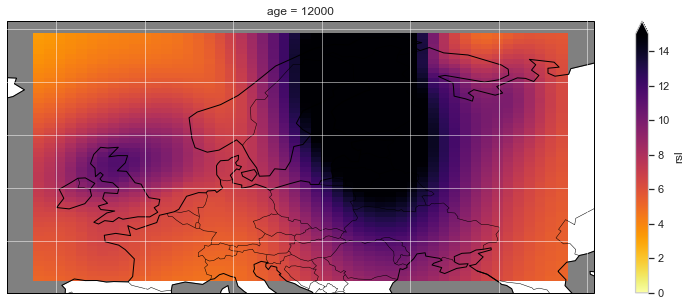

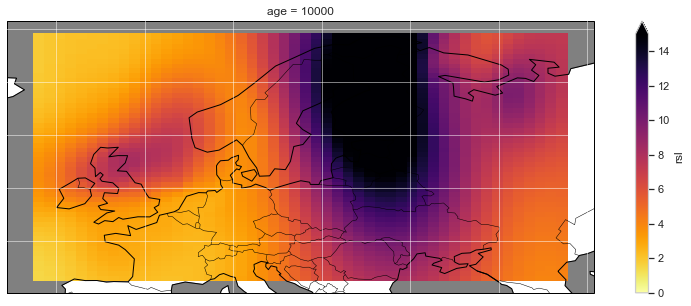

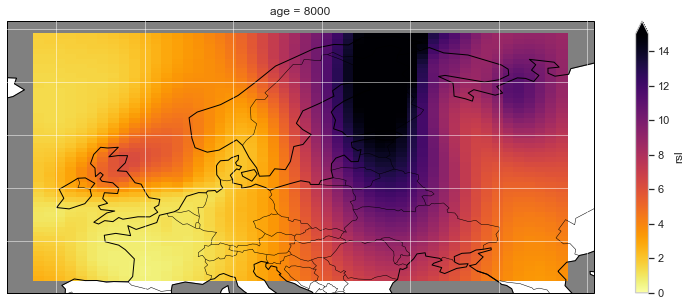

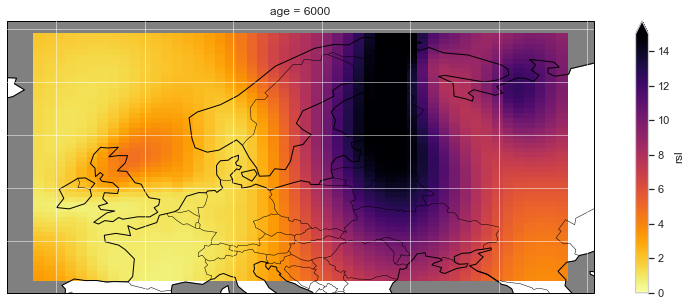

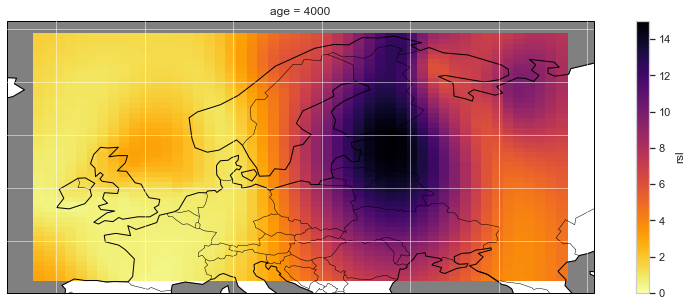

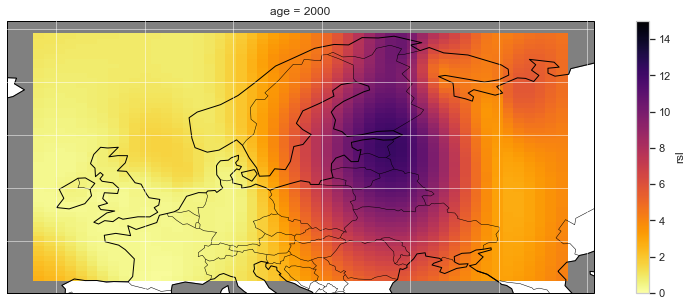

In [220]:
locs = {
                'england': [-12, 2, 50, 60],
                'easternhem': [50, 178, -45, 80],
                'westernhem': [-175, 30, -80, 75],
                'world': [-179.8, 179.8, -89.8, 89.8],
                'namerica': [-150, -20, 10, 75],
                'eastcoast': [-88, -65, 15, 40],
                'europe': [-20, 15, 35, 70],
                'atlantic':[-85,50, 25, 73],
                'fennoscandia': [-15, 50, 45, 73],
            }

def download_files(varname):

    globvar = glob.glob(f'/Users/rogercreel/Desktop/cluster_output/12000*fennoscandia*{varname}')
#     globvar = glob.glob(f'output/12000*fennoscandia*{varname}')

    place = [val.split('_gia')[0].split('_') for val in globvar]
    places = []
    for i, it in enumerate(place):
        [places.append(loc) for loc in it if loc in locs] 

    ds = xr.open_mfdataset(globvar, concat_dim='modelrun', combine='nested')
    try:
        ds = ds.rename({'__xarray_dataarray_variable__':'rsl'})
    except:
        pass
    try:
        ds = ds.drop('scale')
    except:
        pass
    return ds

names = ['giaprior', 'gp_variance', 'da_zp', 'posterior']

ds_giaprior, ds_var, ds_zp, ds_post  = [download_files(it) for it in names]

for i, age in enumerate(ds_zp.age):
    if (age.values / 2000).is_integer():
        fig = plt.figure(figsize=(15, 5)) 
        ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())

        ax.coastlines(resolution='110m', linewidth=1, zorder=2)
        ax.add_feature(cfeature.OCEAN, color='gray', zorder=0)
        # ax.add_feature(cfeature.LAND, color='palegreen', zorder=1)
        ax.add_feature(cfeature.BORDERS, linewidth=0.5, zorder=3)
        ax.gridlines(linewidth=1, color='white', alpha=0.5, zorder=4)

        ds_zp.rsl.std(dim='modelrun').sel(age=age.values).plot(ax=ax, vmin=0, vmax=15, cmap='inferno_r')
        plt.show()

# Calculate RMSE of posterior - prior for all models

Question: is it better to use MAE or RMSE?  If being off by 10 is only twice as bad as being off by 5, then MAE.  But if 10 vs. 5 is more than twice as bad, then RMSE.

In [221]:
extent = locs[place]
tmax=12010
tmin=1990

In [222]:
path = 'data/GSL_LGM_120519_.csv'

df = pd.read_csv(path, encoding="ISO-8859-15", engine='python')
df = df.replace('\s+', '_', regex=True).replace('-', '_', regex=True).\
        applymap(lambda s:s.lower() if type(s) == str else s)
df.columns = df.columns.str.lower()
df.rename_axis('index', inplace=True)
df = df.rename({'latitude': 'lat', 'longitude': 'lon'}, axis='columns')
dfind, dfterr, dfmar = df[(df.type == 0)
                          & (df.age > 0)], df[df.type == 1], df[df.type == -1]
np.sort(list(set(dfind.regionname1)))

#select location
df_place = dfind[(dfind.age > tmin) & (dfind.age < tmax) &
                 (dfind.lon > extent[0])
                 & (dfind.lon < extent[1])
                 & (dfind.lat > extent[2])
                 & (dfind.lat < extent[3])][[
                     'lat', 'lon', 'rsl', 'rsl_er_max', 'age'
                 ]]
df_place.shape

(1794, 5)

In [243]:
out.to_dataframe()

,lat,lon,age,rsl
modelrun,,,,
glac1d_l71C_ump3_lm30,47.51,-2.73,6391.0,-0.207615
glac1d_l71C_ump5_lm50,47.51,-2.73,6391.0,-0.272244
glac1d_l71C_ump4_lm20,47.51,-2.73,6391.0,-0.335907
glac1d_l96C_ump5_lm20,47.51,-2.73,6391.0,-0.265525
d6g_h6g_l71C_ump2_lm3,47.51,-2.73,6391.0,-0.293949
...,...,...,...,...
glac1d_l96C_ump5_lm8,47.51,-2.73,6391.0,-0.253602
glac1d_l96C_ump5_lm40,47.51,-2.73,6391.0,-0.259346
glac1d_l71C_ump5_lm5,47.51,-2.73,6391.0,-0.317072


In [257]:
all_resids = xr.concat(out, dim='modelrun')

In [ ]:
out = []
for i, loc in df_place.iterrows():
    ds_rslresid = (ds_post.rsl.interp(lat=loc.lat, lon=loc.lon, age=loc.age, method='nearest') - loc.rsl)**2
    out.append(ds_rslresid.to_dataframe())
all_resids = pd.concat(out)

In [209]:
xr.ufuncs.sqrt((ds_post.rsl - ds_giaprior.rsl)**2).mean(dim='modelrun')

<xarray.DataArray 'rsl' (modelrun: 82, age: 106, lat: 50, lon: 50)>
dask.array<concatenate, shape=(82, 106, 50, 50), dtype=float64, chunksize=(1, 106, 50, 50), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float64 43.86 44.42 44.98 45.54 ... 69.55 70.11 70.67 71.23
  * age       (age) int64 12000 11900 11800 11700 11600 ... 1800 1700 1600 1500
  * lon       (lon) float64 -11.95 -10.74 -9.539 -8.334 ... 44.7 45.9 47.11
  * modelrun  (modelrun) object 'glac1d_l71C_ump3_lm30' ... 'glac1d_l96C_ump4_lm30'

In [211]:
((ds_post.rsl - ds_giaprior.rsl)**2)

<xarray.DataArray 'rsl' (modelrun: 82, age: 106, lat: 50, lon: 50)>
dask.array<pow, shape=(82, 106, 50, 50), dtype=float64, chunksize=(1, 106, 50, 50), chunktype=numpy.ndarray>
Coordinates:
  * modelrun  (modelrun) object 'glac1d_l71C_ump3_lm30' ... 'glac1d_l96C_ump4_lm30'
  * lat       (lat) float64 43.86 44.42 44.98 45.54 ... 69.55 70.11 70.67 71.23
  * age       (age) int64 12000 11900 11800 11700 11600 ... 1800 1700 1600 1500
  * lon       (lon) float64 -11.95 -10.74 -9.539 -8.334 ... 44.7 45.9 47.11

/anaconda3/envs/gpflow6_0/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


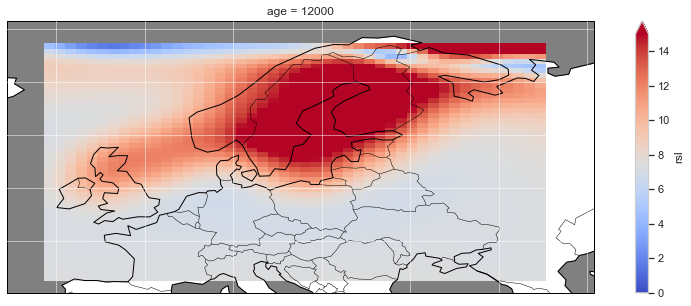

/anaconda3/envs/gpflow6_0/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


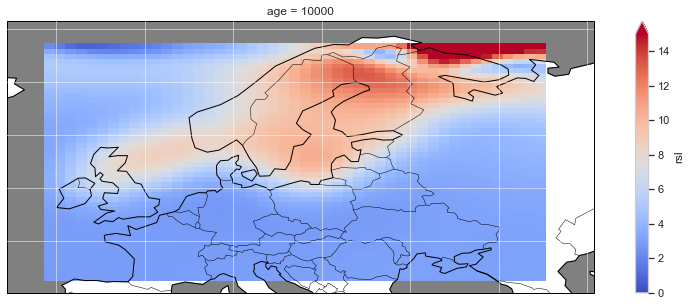

/anaconda3/envs/gpflow6_0/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


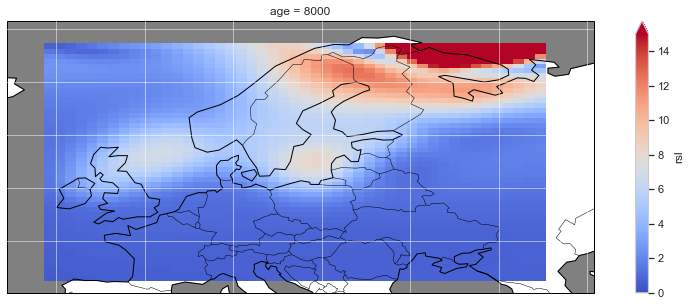

/anaconda3/envs/gpflow6_0/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


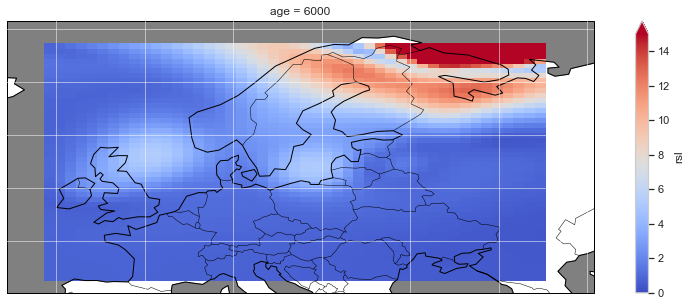

/anaconda3/envs/gpflow6_0/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


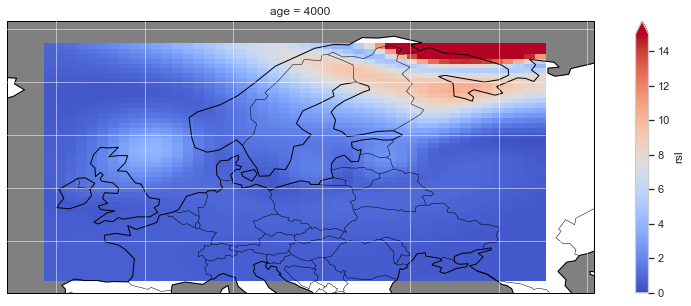

/anaconda3/envs/gpflow6_0/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


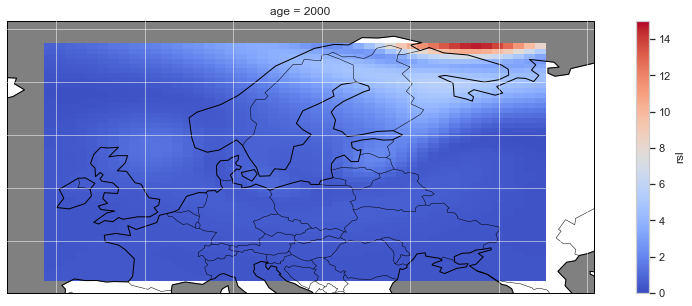

In [215]:
ds_err = xr.ufuncs.sqrt((ds_post.rsl - ds_giaprior.rsl)**2).mean(dim='modelrun')

for i, age in enumerate(ds_zp.age):
    if (age.values / 2000).is_integer():
        fig = plt.figure(figsize=(15, 5)) 
        ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())

        ax.coastlines(resolution='110m', linewidth=1, zorder=2)
        ax.add_feature(cfeature.OCEAN, color='gray', zorder=0)
        # ax.add_feature(cfeature.LAND, color='palegreen', zorder=1)
        ax.add_feature(cfeature.BORDERS, linewidth=0.5, zorder=3)
        ax.gridlines(linewidth=1, color='white', alpha=0.5, zorder=4)

        ds_giaprior.rsl.std(dim='modelrun').sel(age=age.values).plot(ax=ax, vmin=0, vmax=15, cmap='coolwarm')
        plt.show()

In [5]:
def download_files(varname):
    
    globvar = glob.glob(f'output/12000*{varname}')
    lith = ["_".join(val.split('um')[0].split('_')[-2:][:-1]) for val in globvar]
    place = [val.split('_gia')[0].split('_') for val in globvar]
    places = []
    for i, it in enumerate(place):
        [places.append(loc) for loc in it if loc in locs] 
    
    mantle = ["_".join(val.split('C_')[1].split('_')[:2]) for val in globvar]
    model = ["_".join(val.split('_l')[0].split('_')[2:]) for val in globvar]
    ds = xr.open_mfdataset(globvar, concat_dim='mantle', combine='nested')
    ds['mantle'] = mantle

    try:
        ds = ds.rename({'__xarray_dataarray_variable__':'rsl'})
        ds = ds.drop('scale')
#         ds = ds.drop('modelrun')
    except:
        pass
    ds = ds.expand_dims({'lith':lith, 'place':places, 'model':model})
    return ds
names = ['giaprior', 'gp_variance', 'da_zp', 'posterior']
ds_giaprior, ds_var, ds_zp, ds_post  = [download_files(it) for it in names]

In [22]:
test = ds_post.rsl.sel(model='d6g_h6g', place='fennoscandia', lith='l96C').mean(dim=['model', 'place', 'lith']).std(dim=['mantle'])[100]
test = client.persist(test)
test.dask

AttributeError: 'DataArray' object has no attribute 'dask'

In [6]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)

In [18]:
cluster.scale(4)

In [19]:
client

Client Scheduler: tcp://127.0.0.1:51838 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 17.18 GB


In [364]:
ds_post.sel(model='d6g_h6g').mean(dim='modelrun').plot()



KeyError: 10

In [196]:
ds_giaprior = xr.open_mfdataset(gprior, concat_dim='modelrun', combine='nested')
ds_giaprior

<xarray.Dataset>
Dimensions:   (age: 119, lat: 50, lon: 50, modelrun: 103)
Coordinates:
    scale     (age) float64 dask.array<chunksize=(119,), meta=np.ndarray>
  * lon       (lon) float64 -11.95 -10.74 -9.539 -8.334 ... 44.7 45.9 47.11
  * lat       (lat) float64 43.86 44.42 44.98 45.54 ... 69.55 70.11 70.67 71.23
  * age       (age) int64 200 300 400 500 600 ... 11600 11700 11800 11900 12000
  * modelrun  (modelrun) object 'glac1d_l71C_ump5_lm20' ... 'd6g_h6g_l96C_ump5_lm10'
Data variables:
    rsl       (modelrun, lat, lon, age) float64 dask.array<chunksize=(1, 50, 50, 119), meta=np.ndarray>

In [241]:
places = [val.split('_gia')[0].split('_') for val in gprior][0]
places

['output/12000', '2000', 'glac1d', 'l71C', 'ump5', 'lm20', 'fennoscandia']

In [243]:
var[0]

'output/12000_2000_d6g_h6g_l71C_ump5_lm50_fennoscandia_gp_variance'

In [242]:
places = [val.split('_gia')[0].split('_') for val in var][0]
places

['output/12000',
 '2000',
 'd6g',
 'h6g',
 'l71C',
 'ump5',
 'lm50',
 'fennoscandia',
 'gp',
 'variance']

In [282]:
places = [val.split('_gia')[0].split('_') for val in var]


# print(places[4])
number = 2
if "fennoscandia" in places[number]:
    print('in')
elif "atlantic" in places[number]:
    print('out')
# try:
# except:
#     [s for s in places[number] if "atlantic" in s]


out


[]

In [259]:
places = [val.split('_gia')[0].split('_') for val in var]
try:
    [s for s in places[0] if "fennoscandia" in s]
    [s for s in places[0] if "atlantic" in s]
except:
    pass
# places[0]

In [246]:
def clean(ds, modelrun, runs):
    ds = ds.rename({'__xarray_dataarray_variable__':'var'})
    ds = ds.assign_coords({'modelrun':modelrun, 'run':runs, 'place':places})
    return ds


 
gprior = glob_ds('giaprior')
var = glob_ds('variance')
zp = glob_ds('zp')
post = glob_ds('posterior')


runs = [val.split('/')[1].split('_l')[0] for val in gprior]
places = [val.split('_gia')[0].split('_')[-1] for val in gprior][0]
modelrun = ["_".join(val.split('_f')[0].split('_')[2:]) for val in gprior]

ds_giaprior = xr.open_mfdataset(gprior, concat_dim='modelrun', combine='nested')
ds_giaprior = ds_giaprior.assign_coords({'run':runs, 'place':places}).drop('scale')



runs = [val.split('/')[1].split('_l')[0] for val in var]
places = [val.split('_gia')[0].split('_')[-1] for val in var][0]

modelrun = ["_".join(val.split('_f')[0].split('_')[2:]) for val in var]
ds_var = xr.open_mfdataset(var, concat_dim='modelrun', combine='nested')
ds_var = clean(ds_var, modelrun, runs)
ds_var

# runs = [val.split('/')[1].split('_l')[0] for val in zp]
# modelrun = ["_".join(val.split('_f')[0].split('_')[2:]) for val in zp]
# ds_zp = xr.open_mfdataset(zp, concat_dim='modelrun', combine='nested')
# ds_zp = clean(ds_zp, modelrun, runs)
# ds_zp


# ds_var = ds_var.rename({'__xarray_dataarray_variable__':'var'})
# ds_var = ds_var.assign_coords({'modelrun':modelrun, 'run':runs, 'place':places})
# ds_var

<xarray.Dataset>
Dimensions:   (age: 106, lat: 99, lon: 99, modelrun: 63, run: 63)
Coordinates:
  * lon       (lon) float64 -86.48 -83.75 -81.03 -78.3 ... 44.38 44.7 45.9 47.11
  * lat       (lat) float64 23.51 24.48 25.46 26.43 ... 70.11 70.26 70.67 71.23
  * age       (age) int64 12000 11900 11800 11700 11600 ... 1800 1700 1600 1500
  * modelrun  (modelrun) <U43 'd6g_h6g_l71C_ump2_lm30' ... 'd6g_h6g_l71C_ump3_lm5_atlantic_gp_variance'
  * run       (run) <U18 '12000_1500_d6g_h6g' ... '12000_1500_d6g_h6g'
    place     <U8 'variance'
Data variables:
    var       (modelrun, age, lat, lon) float64 dask.array<chunksize=(1, 106, 99, 99), meta=np.ndarray>

In [154]:
del runs


<xarray.Dataset>
Dimensions:   (age: 119, lat: 50, lon: 50, modelrun: 103, place: 103, run: 103)
Coordinates:
  * lon       (lon) float64 -11.95 -10.74 -9.539 -8.334 ... 44.7 45.9 47.11
  * lat       (lat) float64 43.86 44.42 44.98 45.54 ... 69.55 70.11 70.67 71.23
  * age       (age) int64 200 300 400 500 600 ... 11600 11700 11800 11900 12000
  * modelrun  (modelrun) <U22 'd6g_h6g_l71C_ump4_lm40' ... 'd6g_h6g_l71C_ump4_lm3'
  * run       (run) <U18 '12000_2000_d6g_h6g' ... '12000_2000_d6g_h6g'
  * place     (place) <U12 'fennoscandia' 'fennoscandia' ... 'fennoscandia'
Data variables:
    var       (modelrun, age, lat, lon) float64 dask.array<chunksize=(1, 119, 50, 50), meta=np.ndarray>

In [ ]:
tmax = 12000
tmin = 1500

all_files = glob.glob(f'output/12000*d6g_h6g*atlantic*likelihood')
df = pd.concat((pd.read_csv(f, index_col=None) for f in all_files)) 

df['ice_model'] = [key.split('_l')[0] for key in df.modelrun]
df['lith'] = [key.split('_')[-3:][0] for key in df.modelrun]
df['um'] = [key.split('_')[-3:][1][-1] for key in df.modelrun]
df['lm'] = [key.split('_')[-3:][2][2:] for key in df.modelrun]

df.lm = df.lm.astype(float)
df.um = df.um.astype(float)

heatmap = df.pivot_table(index='um', columns='lm', values='log_marginal_likelihood')

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sns.heatmap(heatmap,  cmap='coolwarm', ax=ax,  cbar_kws={'label': 'negative log likelihood'})
# ax.set_title(f'{place} {tmax} - {tmin} yrs \n {ice_model} : {df_likes.lith[0]} km lithosphere');